# Measurements analysis

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from mpl_toolkits.mplot3d import Axes3D

from calculations_annular_valve import MRF

## Data collected
### Reading the .txt files

In [2]:
# It takes 180 seconds
pressures = ["135kPa", "190kPa", "270kPa", "380kPa", "540kPa"]
currents = ["000mA", "050mA", "100mA", "150mA", "200mA", "250mA", "300mA", "350mA",
            "400mA", "450mA", "500mA", "550mA", "600mA", "650mA", "700mA", "750mA",
            "800mA", "850mA", "900mA", "950mA", "1000mA"]
measurements_types = ["V", "P"]
number_measures = 3
data = {}

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    data[P] = {}
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 and not (P == "540kPa" and I == "400mA"):
            print("new I")
            data[P][I] = {}
            for m_type in measurements_types:
                data[P][I][m_type] = [None]*number_measures
                
                # Read the .txt files
                for i in range(number_measures):
                    data[P][I][m_type][i] = np.loadtxt("Sofia_setup_20_12_2021/P_onoff_" + I + "_" + P + "_" + m_type + "_0" + str(i+1) + ".txt",
                                                       delimiter=",", skiprows=5)

new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I
new I


### Plotting the data

In [10]:
# Conversion functions
def conv_P(P):
    return P*202_500 - 203_200
def conv_V(V):
    return (V + 0.897) / 500
def integ_V(V, t):
    time_step = (t[10] - t[0])/10
    integ_V = [0]
    for j in range(len(t)-1):
        integ_V.append(integ_V[j]+V[j]*time_step)
    return integ_V

def recover_numbers(string):
    return int(string[:3])

# Filter functions
def gauss_func(f, freq_cut):
    return np.exp(-0.5*f**2/freq_cut**2)
def filter_data(X, t, freq_cut):
    sp = np.fft.fft(X)
    freq = np.fft.fftfreq(t.shape[-1])
    freq = freq * (1/(t[1]-t[0]))
    
    mask_filter = gauss_func(freq, freq_cut)
    sp_mask = mask_filter * sp
    return np.fft.ifft(sp_mask).real
def filter_data_pass_high(X, t, freq_cut):
    sp = np.fft.fft(X)
    freq = np.fft.fftfreq(t.shape[-1])
    freq = freq * (1/(t[1]-t[0]))
    
    mask_filter = 1 - gauss_func(freq, freq_cut)
    sp_mask = mask_filter * sp
    return np.fft.ifft(sp_mask).real
def AC_conversion(X, t):
    x = X.copy()
    cutoff_freq = 2
    time_step = (t[10] - t[0])/10
    ratio = 1/(2**(time_step*cutoff_freq))
    x_AC = np.zeros(len(x))
    x_AC[0] = x[0]
    for i in range(len(x)-1):
        x_AC[i+1] = ratio*x_AC[i] + (x[i+1]-x[i])
    return x_AC

# Plotting function
def plot_data(V, P, t, labels=["Induced voltage [V]", "Differential pressure [Pa]"], t_char=None):
    fig, ax = plt.subplots(1, 1, figsize=[10, 6])
    axes = [ax, ax.twinx()]
    colors = ('midnightblue', 'crimson')
    for i in range(2):
        ax, color = (axes[i], colors[i])
        if i == 0: data = V
        if i == 1: data = P
        ax.plot(t, data, color=color)
        if i == 0: ax.set_ylabel(labels[0])
        if i == 1: ax.set_ylabel(labels[1])
        if isinstance(t_char, list) and i==1:
            ax.vlines(t_char, np.amin(P), np.amax(P), colors="black")
        ax.tick_params(axis='y', colors=color)
    axes[0].set_xlabel("time [s]")
    plt.show()

# Getting metrics
def integ_metric(V, P, t, sigma_t):
    time_step = (t[10] - t[0])/10
    V_f = filter_data(V, t, 200)
    P_f = filter_data(P, t, 5)
    index1 = np.argmax(np.gradient(P_f))
    index2 = np.argmin(np.gradient(P_f))
    sigma_index = int(sigma_t / time_step)
    return (np.sum(V_f[index1-sigma_index:index1+sigma_index])*time_step,
            np.sum(V_f[index2-sigma_index:index2+sigma_index])*time_step)
def var_metric(V, P, t, sigma_t):
    time_step = (t[10] - t[0])/10
    V_f = filter_data(V, t, 200)
    V_f = V_f - np.mean(V_f)
    P_f = filter_data(P, t, 5)
    index1 = np.argmax(np.gradient(P_f))
    index2 = np.argmin(np.gradient(P_f))
    sigma_index = int(sigma_t / time_step)
    return (np.mean(V_f[index1-sigma_index:index1+sigma_index]**2)**0.5,
            np.mean(V_f[index2-sigma_index:index2+sigma_index]**2)**0.5)

In [45]:
%matplotlib qt

P_string = "135kPa"
I_string = "100mA"

t = data[P_string][I_string]["V"][0][:, 0]

V = conv_V(data[P_string][I_string]["V"][0][:, 1])
V_f = filter_data(V, t, 200)
V_f_AC = AC_conversion(V_f, t)
V_f_integ = integ_V(V_f, t)
V_f_integ_AC = integ_V(V_f_AC, t)

P = conv_P(data[P_string][I_string]["P"][0][:, 1])
P = P - 34458
P_f = filter_data(P, t, 15)

t1 = np.argmax(np.gradient(P_f))
t2 = np.argmin(np.gradient(P_f))

print("t1 : ", t[t1], " t2 : ", t[t1])

#plot_data(V, P, t)
#plot_data(V, P, t)
plot_data(V_f, P_f, t, t_char=[t[t1], t[t2]])
#plot_data(V_f_AC, P_f, t)
#plot_data(V_f_integ, P_f, t)
#plot_data(V_f_integ_AC, P_f, t)

t1 :  -0.0027716065  t2 :  -0.0027716065


In [8]:
np.amin(P_f)

34458.0086091576

### Calculating the metrics

In [21]:
# It takes 90 seconds
pressures = ["135kPa", "190kPa", "270kPa", "380kPa"] # , "540kPa"
currents = ["000mA", "050mA", "100mA", "150mA", "200mA", "250mA", "300mA", "350mA",
            "400mA", "450mA", "500mA", "550mA", "600mA", "650mA", "700mA", "750mA",
            "800mA", "850mA", "900mA", "950mA", "1000mA"]
measurements_types = ["V", "P"]
number_measures = 3
metrics_types = ["integ", "var"]

data_metrics = {}

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    data_metrics[P] = {}
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 and not (P == "135kPa" and I == "000mA"):
            # print(I)
            # data_metrics[P][I] = [{}]*number_measures
            data_metrics[P][I] = {}
            for n in range(number_measures):
                data_metrics[P][I][str(n)] = {}
                for m_type in metrics_types:
                    if m_type == "var":
                        if P == "540kPa":
                            data_metrics[P][I][str(n)][m_type] = var_metric(data[P][I]["V"][n][:, 1]/500,
                                                                       conv_P(data[P][I]["P"][n][:, 1]),
                                                                       data[P][I]["V"][n][:, 0],
                                                                       0.1)
                        else:
                            data_metrics[P][I][str(n)][m_type] = var_metric(conv_V(data[P][I]["V"][n][:, 1]),
                                                                       conv_P(data[P][I]["P"][n][:, 1]),
                                                                       data[P][I]["V"][n][:, 0],
                                                                       0.1)
                    if m_type == "integ":
                        if P == "540kPa":
                            data_metrics[P][I][str(n)][m_type] = integ_metric(data[P][I]["V"][n][:, 1]/500,
                                                                         conv_P(data[P][I]["P"][n][:, 1]),
                                                                         data[P][I]["V"][n][:, 0],
                                                                         0.1)
                        else:
                            data_metrics[P][I][str(n)][m_type] = integ_metric(conv_V(data[P][I]["V"][n][:, 1]),
                                                                     conv_P(data[P][I]["P"][n][:, 1]),
                                                                     data[P][I]["V"][n][:, 0],
                                                                     0.1)

### Plotting the 3D plot of P and I

In [24]:
%matplotlib qt

In [75]:
# NORMAL GRAPHS
m_type = "integ"
number_measures = 3

by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.TABLEAU_COLORS.items())
names = [name for hsv, name in by_hsv]

fig, ax = plt.subplots(1, 1, figsize=[10, 6])

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 and not (P == "135kPa" and I == "000mA"):
            for n in range(number_measures):
                line = ax.scatter(recover_numbers(I), -1000*data_metrics[P][I][str(n)][m_type][1], c=names[counter_P], alpha=0.7)
                if counter_I == counter_P*2 + 1 and n == 0:
                    line.set_label(P)

ax.legend()
#ax.set_ylim([-0.001, 0.010])
ax.set_xlabel('Current [mA]')
ax.set_ylabel('Integral of the induced voltage [mVs]')

plt.show()

In [79]:
# R VALUE GRAPHS
m_type = "integ"
number_measures = 3

Ns = 174
Ne = 135
g = 0.0005
S = 0.00011
mu0 = 0.000001257
phi = 0.33
alph = 2*g/(Ns*Ne*mu0*S*phi)
r0 = 0.938

by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.TABLEAU_COLORS.items())
names = [name for hsv, name in by_hsv]

fig, ax = plt.subplots(1, 1, figsize=[10, 6])

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 and not (P == "135kPa" and I == "000mA"):
            for n in range(number_measures):
                i = recover_numbers(I)/1000
                IV = data_metrics[P][I][str(n)][m_type][1]
                line = ax.scatter(recover_numbers(I),
                                  1 - (1-r0) / (1-(1-r0)*alph*IV/i),
                                  c=names[counter_P], alpha=0.7)
                if counter_I == counter_P*2 + 1 and n == 0:
                    line.set_label(P)

ax.legend()
#ax.set_ylim([0.93794, 0.93802])
ax.set_xlabel('Current [mA]')
ax.set_ylabel('r value [-]')

plt.show()

In [59]:
m_type = "integ"
number_measures = 3

by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.TABLEAU_COLORS.items())
names = [name for hsv, name in by_hsv]

fig, ax = plt.subplots(1, 1, figsize=[10, 6])

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 and I == "500mA":
            for n in range(number_measures):
                line = ax.scatter(recover_numbers(P), 1000*np.abs(data_metrics[P][I][str(n)][m_type][1]), c=names[counter_I%8], alpha=0.7)

ax.legend()
#ax.set_ylim([-0.001, 0.010])
ax.set_xlabel('Current [mA]')
ax.set_ylabel('Integral of the induced voltage [mVs]')

plt.show()

No handles with labels found to put in legend.


## Reproduction of the results with model based simulations

### Single use

In [80]:
def interpolation_20(X):
    nb_step = 300_000
    ret = np.zeros(nb_step)
    for i in range(len(X)-1):
        for j in range(20):
            ret[i*20 + j] = X[i] * (20 - j) / 20 + X[i+1] * j / 20
    for i in range(20):
        ret[-(i+1)] = ret[-21]
    return ret

In [110]:
nb_step = 300_000

# Constant current
i_max = 0.5/2 # because double gap
i = np.ones(nb_step)*i_max

t = data["270kPa"]["200mA"]["P"][0][:, 0]
V = conv_V(data["270kPa"]["200mA"]["V"][0][:, 1])
V_f = filter_data(V, t, 200)
P = conv_P(data["270kPa"]["200mA"]["P"][0][:, 1])
P_f = filter_data(P, t, 5)
dP_f = P_f - P_f[2500]
dP_f = np.abs(dP_f[2500:17500])
dP_f_resample = interpolation_20(dP_f)

In [114]:
analysis = MRF(step_t=1*10**(-6), nb_step=nb_step,
               fi=0.302, d=math.pi*2*(0.0069 + 0.00025), g=0.0005, length=0.0025,
               N_e=135.5, N_s=174.5, b=1, # d_eff_disp=0.0001,
               i=i, dP=dP_f_resample)

analysis.run()

print("Yield stress pressure drop : ", analysis.tau[0])
print("H : ", analysis.H[0], " B : ", analysis.H[0]*1.25*10**(-6))

Text(0.5, 0, 'time [s]')

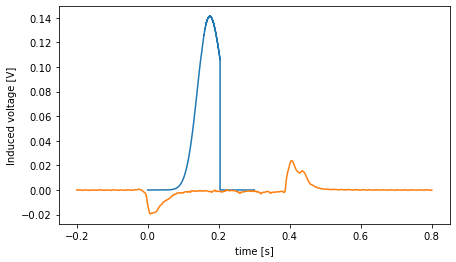

In [115]:
t_sim = np.linspace(0, 1, analysis.nb_step)
t_sim = t_sim * (analysis.nb_step - 1) * analysis.step_t

fig, ax = plt.subplots(1, 1, figsize=[7, 4])
ax.plot(t_sim, analysis.v)
ax.plot(t, V_f*10)
ax.set_ylabel("Induced voltage [V]")
ax.set_xlabel("time [s]")

### All data simulation

In [149]:
# It takes 90 seconds
pressures = ["135kPa", "190kPa", "270kPa", "380kPa", "540kPa"]
currents = ["000mA", "050mA", "100mA", "150mA", "200mA", "250mA", "300mA", "350mA",
            "400mA", "450mA", "500mA", "550mA", "600mA", "650mA", "700mA", "750mA",
            "800mA", "850mA", "900mA", "950mA", "1000mA"]
measurements_types = ["V", "P"]

data_sim = {}

nb_step = 300_000

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    data_sim[P] = {}
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 \
            and not (P == "540kPa" and I == "400mA") and not (P == "135kPa" and I == "000mA"):
            print("Current current : ", I)
            
            i_max = recover_numbers(I)/2000 # because double gap and mA
            i = np.ones(nb_step)*i_max

            t = data[P][I]["P"][0][:, 0]
            P_signal = conv_P(data[P][I]["P"][0][:, 1])
            P_signal_f = filter_data(P_signal, t, 5)
            dP_f = P_signal_f - P_signal_f[2500]
            dP_f = np.abs(dP_f[2500:17500])
            dP_f_resample = interpolation_20(dP_f)
            
            analysis = MRF(step_t=1*10**(-6), nb_step=nb_step,
                           fi=0.302, d=math.pi*2*(0.0069 + 0.00025), g=0.0005, length=0.0025,
                           N_e=135.5, N_s=174.5, b=0.1, # d_eff_disp=0.0001,
                           i=i, dP=dP_f_resample)
            analysis.run()

            t_sim = np.linspace(0, 1, analysis.nb_step)
            t_sim = t_sim * (analysis.nb_step - 1) * analysis.step_t
            print(P, I)
            data_sim[P][I] = (t_sim, analysis.v)

Current current :  050mA
135kPa 050mA
Current current :  100mA
135kPa 100mA
Current current :  150mA
135kPa 150mA
Current current :  200mA
135kPa 200mA
Current current :  250mA
135kPa 250mA
Current current :  300mA
135kPa 300mA
Current current :  350mA
135kPa 350mA
Current current :  400mA
135kPa 400mA
Current current :  450mA
135kPa 450mA
Current current :  500mA
135kPa 500mA
Current current :  100mA
190kPa 100mA
Current current :  150mA
190kPa 150mA
Current current :  200mA
190kPa 200mA
Current current :  250mA
190kPa 250mA
Current current :  300mA
190kPa 300mA
Current current :  350mA
190kPa 350mA
Current current :  400mA
190kPa 400mA
Current current :  450mA
190kPa 450mA
Current current :  500mA
190kPa 500mA
Current current :  550mA
190kPa 550mA
Current current :  600mA
190kPa 600mA
Current current :  200mA
270kPa 200mA
Current current :  250mA
270kPa 250mA
Current current :  300mA
270kPa 300mA
Current current :  350mA
270kPa 350mA
Current current :  400mA
270kPa 400mA
Current curr

C:\Users\timot\Documents\calculations_annular_valve.py:120: RuntimeWarning: overflow encountered in double_scalars
  """Calculate the magnetic permitivity."""
C:\Users\timot\Documents\calculations_annular_valve.py:120: RuntimeWarning: invalid value encountered in double_scalars
  """Calculate the magnetic permitivity."""


380kPa 750mA
Current current :  800mA
380kPa 800mA
Current current :  450mA
540kPa 450mA
Current current :  500mA
540kPa 500mA
Current current :  550mA
540kPa 550mA
Current current :  600mA
540kPa 600mA
Current current :  650mA
540kPa 650mA
Current current :  700mA
540kPa 700mA
Current current :  750mA
540kPa 750mA
Current current :  800mA
540kPa 800mA
Current current :  850mA
540kPa 850mA
Current current :  900mA
540kPa 900mA


In [143]:
%matplotlib qt

In [154]:
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in mcolors.TABLEAU_COLORS.items())
names = [name for hsv, name in by_hsv]

fig, ax = plt.subplots(1, 1, figsize=[10, 6])

# construction of the data architecture
for counter_P, P in enumerate(pressures):
    for counter_I ,I in enumerate(currents):
        if counter_I >= counter_P*2 and counter_I <= 10 + counter_P*2 \
            and not (P == "540kPa" and I == "400mA") and not (P == "135kPa" and I == "000mA"):
            # print(recover_numbers(I))
            line = ax.scatter(recover_numbers(I), np.sum(data_sim[P][I][1])/10**6, c=names[counter_P], alpha=0.3)
            if counter_I == counter_P*2 + 1:
                line.set_label(P)

ax.legend()
ax.set_xlabel('Current [mA]')
ax.set_ylabel('metric [Vs]')

plt.show()

In [152]:
plt.plot(data_sim["540kPa"]["700mA"][1])

## Test impact of auto induction

In [40]:
def L_evolution(t):
    value = 0.001
    factor = 3
    if t < 0.25:
        return value
    if t > 0.75:
        return value * factor
    return value + (t - 0.25) * 2 * value * (factor-1)

N = 1000
dt = 1/N
V = np.ones(N)
t = np.linspace(0, 1, N)
R = 4
L = np.array(list(map(L_evolution, t)))

V_ind = np.zeros(N)
V_ind_approx = np.zeros(N)
i = np.zeros(N)
i_cte = V[0]/R
i[0] = V[0]/R

In [41]:
for step in range(1, N):
    i[step] = (V[step] + L[step-1]*i[step-1]/dt) / (R + L[step]/dt)
    V_ind[step] = (L[step]*i[step] - L[step-1]*i[step-1])/dt
    V_ind_approx[step] = (L[step]*i_cte - L[step-1]*i_cte)/dt

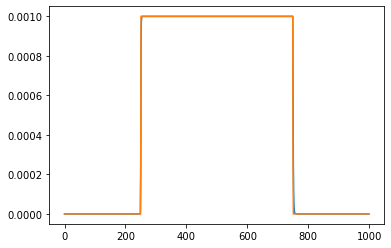

In [42]:
plt.plot(V_ind)
plt.plot(V_ind_approx)

### Figure for report